Learn iterator for multiphase elastic problems using SAC-FEANet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from functools import reduce

from utils import plot
import feanet.pac as pac
from feanet.model import PACFEANet
from feanet.jacobi import JacobiBlock
from data.dataset import ElasticityDataSet

In [2]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    '''
    def __init__(self, size, n_elem, mode, dev):
        self.size = size # actual size of the plate
        self.mode = mode
        self.device = dev
        self.n_elem = n_elem
        self.h = size/n_elem
        self.v, self.f = None, None
        self.net = self.InstantiateNetwork()
        self.jac = JacobiBlock(self.net, self.h, self.device, self.mode)

    def IsCoarsest(self):
        return self.n_elem == 2
        
    def InstantiateNetwork(self):
        model = PACFEANet(self.device, self.mode).double()
        model.requires_grad_(False)
        return model.to(self.device)

Test SAC-FEANet for elastic problems

In [4]:
model_name = 'elasticity_type1_2d_33x33'
training_set = ElasticityDataSet('data/elasticity_planestress/elasticity_type1_2d_33x33.h5', device)
model_dir = 'model/learn_iterator/elasticity_type1'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

bs = 8
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, fbody_train, usol_train = next(iter(train_dataloader))
k = 0 # the index of training data to be shown

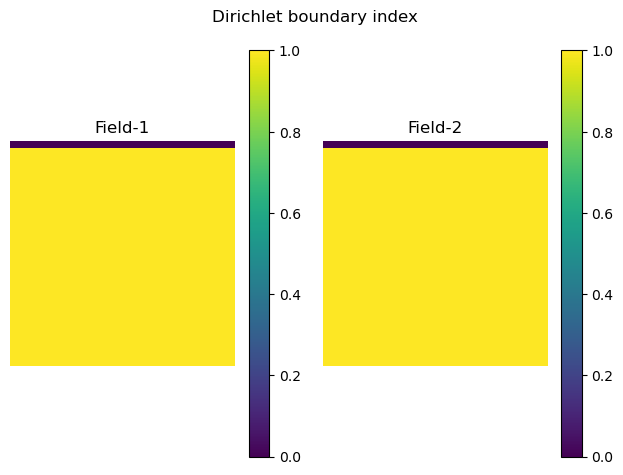

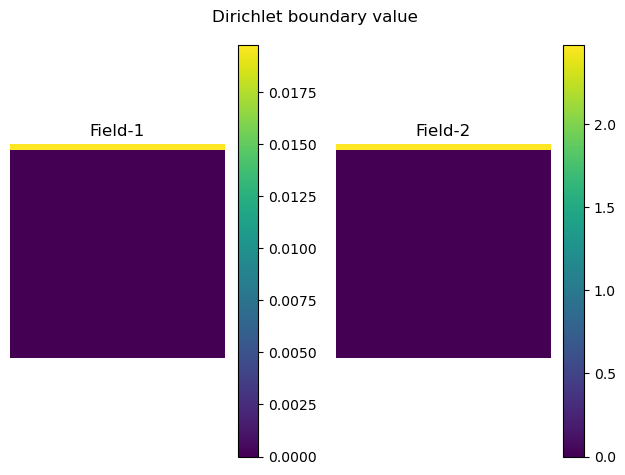

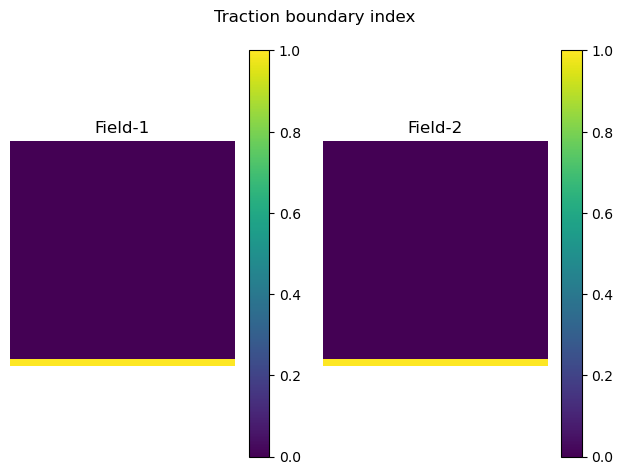

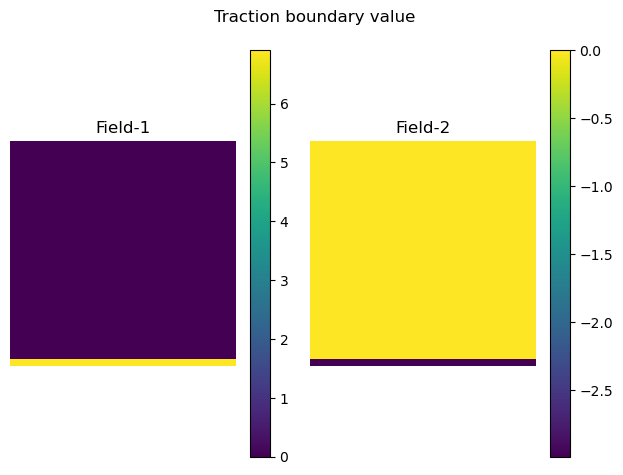

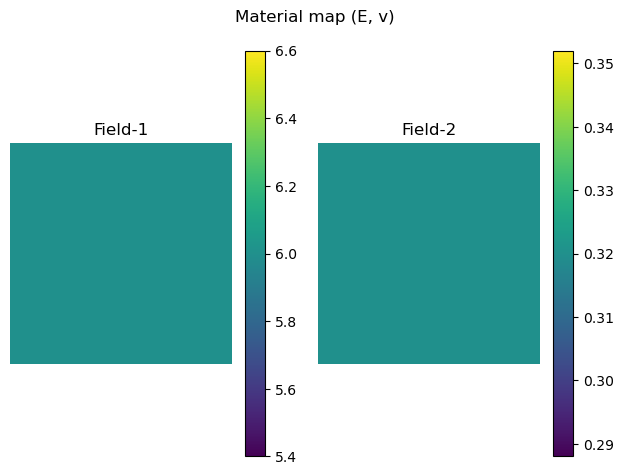

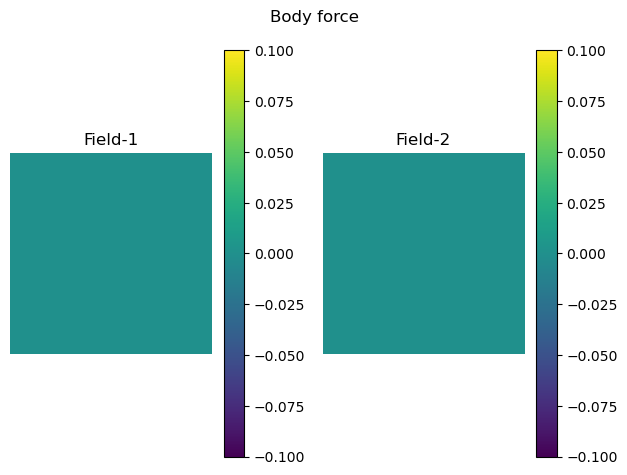

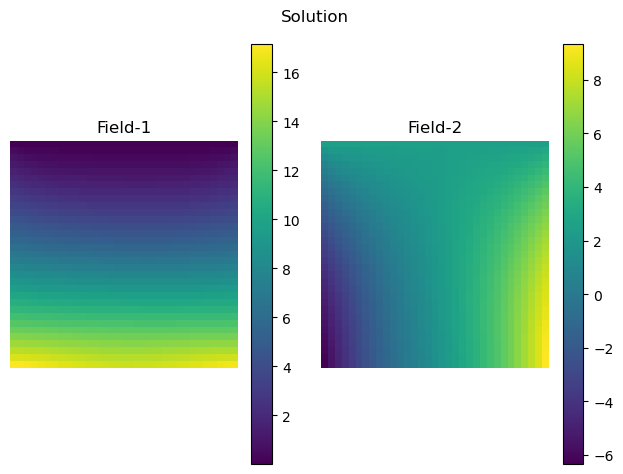

In [5]:
plot.plot_elasticfield(dirich_idx_train[k], ftitle='Dirichlet boundary index')
plot.plot_elasticfield(dirich_value_train[k], ftitle='Dirichlet boundary value')
plot.plot_elasticfield(traction_idx_train[k], ftitle='Traction boundary index')
plot.plot_elasticfield(traction_value_train[k], ftitle='Traction boundary value')
plot.plot_elasticfield(material_train[k], ftitle='Material map (E, v)')
plot.plot_elasticfield(fbody_train[k], ftitle='Body force')
plot.plot_elasticfield(usol_train[k], ftitle='Solution')

In [6]:
domain_size = 2
n_elem = 2**5
ku, kf = 2, 2
h = domain_size/n_elem
grid = SingleGrid(domain_size, n_elem=n_elem, mode='elastic', dev=device_predict)

In [7]:
EPS = 1e-6
n_jac = 0
u_train = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
solution_train, f_train, d_train, d_idx_train, t_train, t_idx_train, m_train = (torch.unsqueeze(usol_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(fbody_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(traction_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(traction_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


0 56.92412802037128


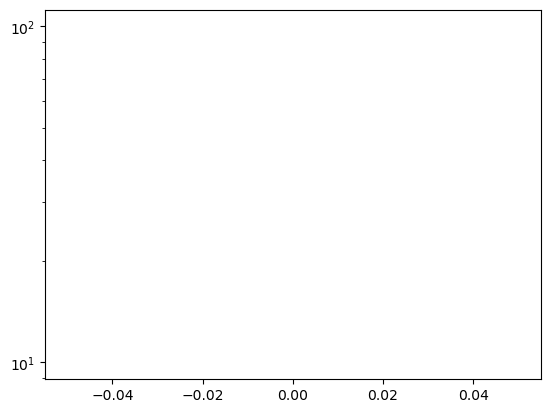

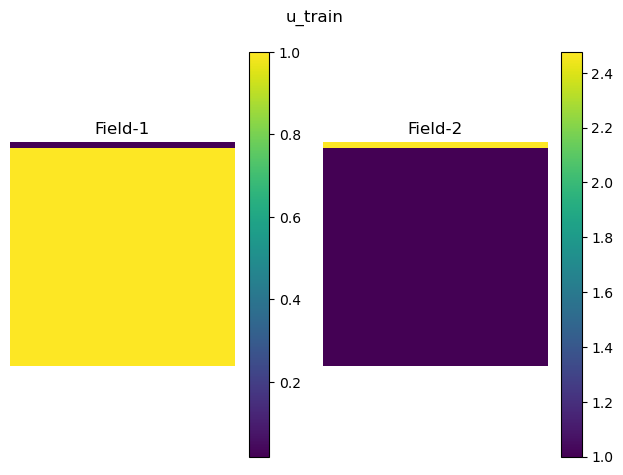

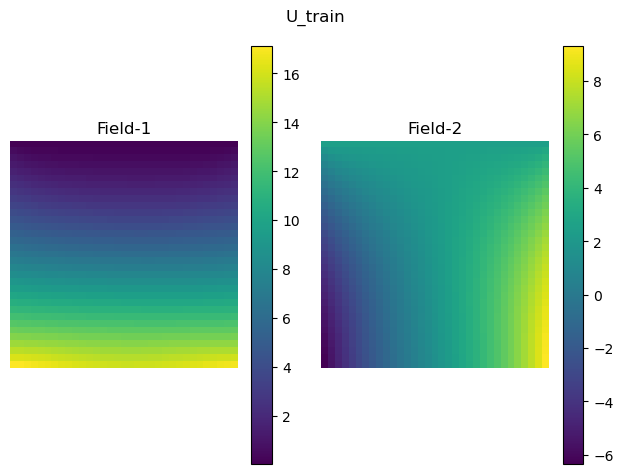

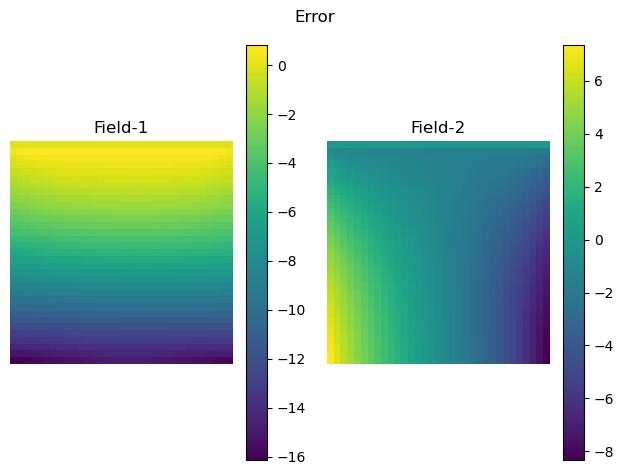

In [8]:
u_train = grid.jac.reset_boundary(u_train, d_train, d_idx_train)
residual = d_idx_train*grid.net(None, None, h, u_train, f_train, t_train, t_idx_train, m_train)
res = torch.norm(residual).item() # fix top, apply traction force at bottom boundary
res_arr = [res]
print(n_jac, res)

'''
while (abs(res) > EPS):
    u_test = grid.jac.jacobi_convolution(h, u_train, f_train, t_train, t_idx_train, d_train, d_idx_train, m_train)
    residual = grid.net(h, u_train, f_train, t_train, t_idx_train, m_train)
    res = torch.norm(residual[:, :, 1:, :]).item()
    res_arr.append(res)
    n_jac += 1
    print(n_jac, res)

print("Solution converges after", n_jac, "Jacobi iterations ")
'''

plt.plot(res_arr)
plt.yscale('log')
plt.show()

plot.plot_elasticfield(u_train[0], "u_train")
plot.plot_elasticfield(solution_train[0], "U_train")
plot.plot_elasticfield(u_train[0]-solution_train[0], 'Error')

In [9]:
class PsiNet(nn.Module):
    def __init__(self, nb_layers=3, mode='thermal'):
        super(PsiNet, self).__init__()

        self.mode = mode
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2
            
        '''
        self.attention_map = nn.Sequential(
            nn.Conv2d(self.km, 1, kernel_size=2, padding=1),
            nn.Conv2d(1, 1, kernel_size=5, padding=2),
            nn.Conv2d(1, self.ku, kernel_size=1, padding=0),
            nn.BatchNorm2d(num_features=self.ku),
            nn.Unfold(kernel_size=3, padding=1),
            nn.Sigmoid()
            )
        '''

        self.smoother = nn.ModuleList([nn.Conv2d(self.ku, self.ku, 3, padding=1, bias=False, groups=self.ku)
                                         for _ in range(nb_layers)])

    def forward(self, m, x, dirich_idx):
        '''
        m: material field
        x: error between Jacobi solution and initial guess '''
        #bs0, ku0, h0, w0 = x.size()
        #new_x = F.unfold(x, kernel_size = 3, padding = 1).view(bs0, ku0, -1, h0, w0) # shape (bs, ku, 9, h, w)
        #attention = self.attention_map(m).view(bs0, ku0, -1, h0, w0) # shape (bs, ku, 9, h, w)
        #attention_x = new_x * attention # shape (bs, ku, 9, h, w)
        #attention_x = attention_x.sum(dim=2) # shape (bs, ku, h, w)
        return reduce(lambda acc, el: el(acc) * dirich_idx, self.smoother, x) # shape (bs, ku, h, w)

In [10]:
class PsiIterator(nn.Module):
    def __init__(self, 
                 dev,
                 size=2, 
                 psi_net=None,
                 grid=None,
                 n=2**5,
                 batch_size=1,
                 max_epochs=1000,
                 mode='thermal',
                 model_dir=model_dir):
        super(PsiIterator, self).__init__()
        self.size = size
        self.device = dev
        self.n = n
        self.h = size/n
        self.mode = mode
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.loss = nn.MSELoss(reduction='sum')
        
        if(grid is None):
            self.grid = SingleGrid(size, n, mode=mode, dev=self.device)
        else:
            self.grid = grid

        if(psi_net is None):
            self.psi_net = PsiNet(nb_layers=3, mode=self.mode).to(self.device).double()
        else:
            self.psi_net = psi_net.to(self.device).double()

        self.optimizer = torch.optim.Adadelta(self.psi_net.parameters())
        self.model_dir=model_dir

    def PsiRelax(self, v, m, d, d_idx, term_KU=None, term_F=None, h=None, f=None, t=None, t_idx=None, num_sweeps_down=1):
        '''
        Perform a fixed number of Psi iteration
        '''
        u = v.clone()
        for _ in range(num_sweeps_down):
            jac_it = self.grid.jac.jacobi_convolution(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx)
            u = jac_it + self.psi_net(m, jac_it-u, d_idx) 
        return u

    def RandomSampling(self, x):
        u = torch.randn_like(x).double().to(self.device)
        return u

    def TrainSingleEpoch(self, train_dataloader):
        running_loss = 0.
        for i, data in enumerate(train_dataloader):
            dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, f_train, u_train = data
        
            #print(u_train.shape)
            self.optimizer.zero_grad() # zero the gradients for every batch
            k = 1 #random.randint(1,20)

            uu = self.RandomSampling(f_train)
            u_out = self.PsiRelax(self.h, uu, f_train, traction_value_train, traction_idx_train, dirich_value_train, dirich_idx_train, material_train, k)
            loss_i = self.loss(u_out, u_train)
            loss_i.backward()
            self.optimizer.step()
        
            running_loss += loss_i.item()
    
        last_loss = running_loss/(i+1)
        return last_loss
    
    def Train(self, training_set):
        train_dataloader = DataLoader(training_set, batch_size=self.batch_size, shuffle=True)
        loss_train = torch.zeros((self.max_epochs, 1))
        avg_loss = self.TrainSingleEpoch(train_dataloader)
        loss_train[0] = avg_loss
        print('Step-0 loss:', avg_loss)

        for epoch in range(1, self.max_epochs):
            avg_loss = self.TrainSingleEpoch(train_dataloader)
            if(epoch % 50 == 0):
                print('Step-'+str(epoch)+' loss:', avg_loss)

            # save the model's state
            mpath = os.path.join(self.model_dir,model_name+'.pth')
            torch.save(self.psi_net.state_dict(), mpath)
            loss_train[epoch] = avg_loss
        return loss_train

In [11]:
'''
my_iterator = PsiIterator(device, batch_size=bs, mode='elastic', max_epochs=2000)
loss_train = my_iterator.Train(training_set)

plt.plot(loss_train)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
print("Average loss: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

# save the list
torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))
'''

'\nmy_iterator = PsiIterator(device, batch_size=bs, mode=\'elastic\', max_epochs=2000)\nloss_train = my_iterator.Train(training_set)\n\nplt.plot(loss_train)\nplt.ylabel(\'loss\')\nplt.yscale(\'log\')\nplt.xlabel(\'epoch\')\nprint("Average loss: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))\n\n# save the list\ntorch.save(loss_train, os.path.join(model_dir,model_name+\'.pt\'))\n'

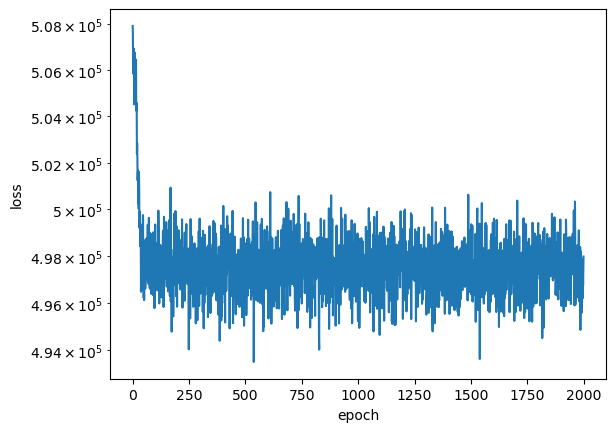

In [12]:
# import the learned model and loss train
my_net = PsiNet(mode='elastic').to(device_predict)
my_net.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))
new_iterator = PsiIterator(device_predict, psi_net=my_net, n=n_elem, batch_size=1, mode='elastic')

my_loss = torch.load(os.path.join(model_dir,model_name+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

0 56.92412802037128
1 19.396282341205275
2 9.80530970848247
3 7.1690365512627805
4 6.001029318874691
5 5.271062517749355
6 5.016970043121652
7 4.781292772289417
8 4.993662519223436
9 5.1734194642569715
10 6.193346274176138
11 7.584351285018578
12 10.6890783031494
13 15.243085643583592
14 23.08810805478679
15 34.93996354171266
16 53.871591093768636
17 83.01951656510695
18 128.63855471482327
19 199.37715906177516
20 309.4781036487026
21 480.5482817361382
22 746.5170627227319
23 1160.0434926203618
24 1802.9858955253662
25 2802.863824578596
26 4358.036424455887
27 6778.0754454229755
28 10544.370966421659
29 16400.535587076698
30 25475.852689125182
31 39443.44772754335
32 60699.974914570485
33 92541.95503734658
34 139289.54982552925
35 206286.51503728086
36 299679.5123066594
37 425877.8899683352
38 590647.7281170802
39 797992.2621745908
40 1049490.0553858383
41 1345965.2795775526
42 1695767.771695067
43 2137081.196628042
44 2778675.898158958
45 3837472.005484741
46 5623420.093605776
47 8478

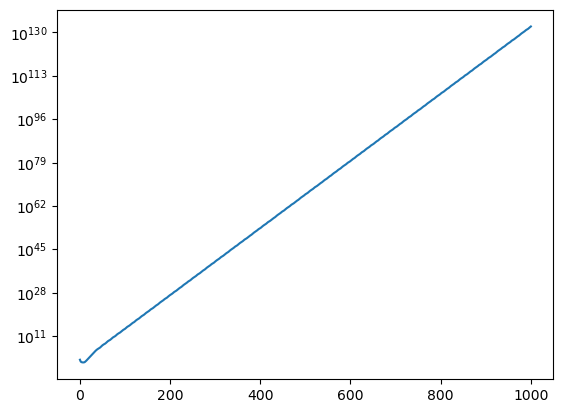

In [13]:
EPS = 1e-6
n_new = 0
u_train = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
u_train = new_iterator.grid.jac.reset_boundary(u_train, d_train, d_idx_train)
residual = d_idx_train*new_iterator.grid.net(h, u_train, f_train, t_train, t_idx_train, m_train)
res = torch.norm(residual).item() # fix top, apply traction force at bottom boundary
res_arr_new = [res]
print(n_new, res)
while (abs(res) > EPS and n_new < 1000):
    u_train = new_iterator.PsiRelax(h, u_train, f_train, t_train, t_idx_train, d_train, d_idx_train, m_train, 1)
    residual = d_idx_train*new_iterator.grid.net(h, u_train, f_train, t_train, t_idx_train, m_train)
    res = torch.norm(residual).item()
    res_arr_new.append(res)
    n_new += 1
    print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new)
plt.yscale('log')


In [14]:
# test on larger grid
n_elem = 2**6
test_set = ElasticityDataSet('data/elasticity_planestress/elasticity_type1_2d_65x65.h5', device=device)
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=True)
dirich_idx_test, dirich_value_test, traction_idx_test, traction_value_test, material_test, fbody_test, usol_test = next(iter(test_dataloader))

solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(usol_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(fbody_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(traction_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(traction_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_test[k], 0).to(device_predict))
#plot.plot_elasticfield(solution_test[k])
#plot.plot_elasticfield(d_test[k])
#lot.plot_elasticfield(t_test[k])

In [15]:
test_iterator = PsiIterator(device_predict, psi_net=my_net, n=2**6, batch_size=1, mode='elastic')


0 65.91783452345042
1 45.48777770019705
2 34.38450624238136
3 25.9129630904096
4 20.027887981087932
5 15.745731607350159
6 12.968201374286858
7 11.026281605914997
8 10.048637055289543
9 9.46692161511744
10 9.916512188061764
11 10.880022731794146
12 13.829157669837947
13 18.42816831489431
14 26.95047175193847
15 39.88993374358088
16 60.988448024706976
17 93.34261026653736
18 144.43236063523858
19 223.64295941980586
20 347.8967385880816
21 541.8411099344504
22 846.0685668983048
23 1322.9109499870353
24 2072.1700230202996
25 3250.062198897328
26 5104.709757251104
27 8027.472931179054
28 12639.038934127366
29 19922.05171024017
30 31435.94370706782
31 49655.336882320895
32 78512.46146086228
33 124258.77487786303
34 196842.4754771688
35 312104.8248481552
36 495291.4395918389
37 786662.5631958834
38 1250469.328202435
39 1989317.5235398114
40 3167172.3555691796
41 5046216.455665673
42 8045941.906251446
43 12837930.587908514
44 20497958.78221809
45 32750204.51588771
46 52359512.613405965
47 837

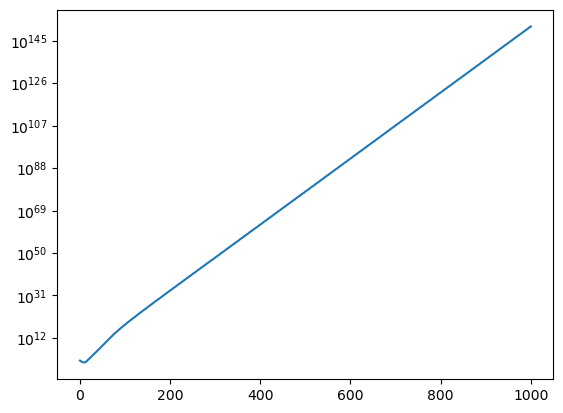

In [16]:
EPS = 1e-6
n_new = 0
u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
u_test = test_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
residual = d_idx_test*test_iterator.grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual).item() # fix top, apply traction force at bottom boundary
res_arr_new = [res]
print(n_new, res)
while (abs(res) > EPS and n_new < 1000):
    u_test = test_iterator.PsiRelax(h, u_test, f_test, t_test, t_idx_test, d_test, d_idx_test, m_test, 1)
    residual = d_idx_test*test_iterator.grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    res_arr_new.append(res)
    n_new += 1
    print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new)
plt.yscale('log')

0 65.91783452345042
1 47.02961407185379
2 37.20345644752207
3 30.891417774929202
4 26.52122110293683
5 23.336874396085207
6 20.913357977912035
7 19.006940705376476
8 17.46499117146173
9 16.190397113702033
10 15.117325389656694
11 14.200313759945443
12 13.406614227426992
13 12.712205860879386
14 12.098969701262693
15 11.55301599070681
16 11.063488672517122
17 10.621785465695723
18 10.220992097741567
19 9.855487151100993
20 9.520649579753417
21 9.212644461355325
22 8.928260868920056
23 8.664788953051065
24 8.419924899065528
25 8.191696961062531
26 7.978407130467664
27 7.778584782730667
28 7.590949476148003
29 7.4143808737814485
30 7.247894230173733
31 7.090620277717675
32 6.941788611910543
33 6.800713883627424
34 6.666784257317299
35 6.539451711259249
36 6.418223844120358
37 6.302656920654449
38 6.1923499422617745
39 6.086939569644678
40 5.986095757377877
41 5.889517986062316
42 5.796931998308313
43 5.708086961294923
44 5.62275299194394
45 5.540718991515829
46 5.4617907451995915
47 5.385

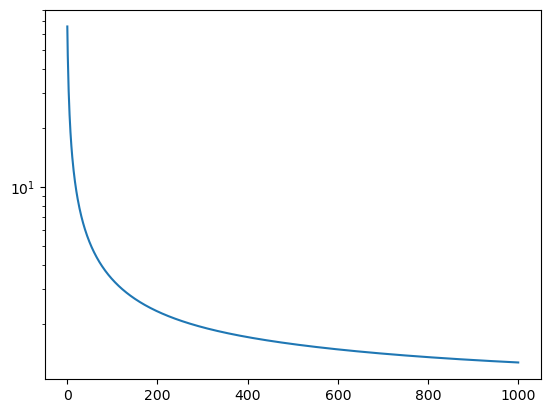

In [17]:
EPS = 1e-6
n_jac = 0
u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
u_test = test_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
residual = d_idx_test*test_iterator.grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual).item() # fix top, apply traction force at bottom boundary
res_arr_new_jac = [res]
print(n_jac, res)

while (abs(res) > EPS and n_jac < 1000):
    u_test = test_iterator.grid.jac.jacobi_convolution(h, u_test, f_test, t_test, t_idx_test, d_test, d_idx_test, m_test)
    residual = d_idx_test*test_iterator.grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    res_arr_new_jac.append(res)
    n_jac += 1
    print(n_jac, res)

print("Solution converges after", n_jac, "iterations ")
plt.plot(res_arr_new_jac)
plt.yscale('log')

In [18]:
# test multigrid performance

class RestrictionNet(nn.Module):
    '''Given an initial kernel, inter-grid communication'''
    def __init__(self, chs):
        super(RestrictionNet, self).__init__()
        self.chs = chs
        self.net = nn.Conv2d(in_channels=chs, out_channels=chs, kernel_size=3, stride=2, bias=False, groups=chs) # restriction
        self.edge_net = nn.Conv1d(in_channels=chs, out_channels=chs, kernel_size=3, stride=2, bias=False, groups=chs) # restrict the edge boundaries
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
            self.edge_net.state_dict()['weight'][i][0] = torch.asarray([1., 2., 1.]) / 2.0
    
    def forward(self, x):
        internal = self.net(x[:, :, 1:-1, 1:-1].clone())
        x_C = F.pad(internal,(1,1,1,1),"constant",0) # coarse grid field
        x_C[:, :,  0, 1:-1] = self.edge_net(x[:, :, 0, 1:-1].clone())
        x_C[:, :, -1, 1:-1] = self.edge_net(x[:, :, -1, 1:-1].clone())
        x_C[:, :, 1:-1,  0] = self.edge_net(x[:, :, 1:-1, 0].clone())
        x_C[:, :, 1:-1, -1] = self.edge_net(x[:, :, 1:-1, -1].clone())
        x_C[:,:,0,0] = x[:,:,0,0]
        x_C[:,:,0,-1] = x[:,:,0,-1]
        x_C[:,:,-1,0] = x[:,:,-1,0]
        x_C[:,:,-1,-1] = x[:,:,-1,-1]
        return x_C


class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, chs):
        super(ProlongationNet, self).__init__()
        self.chs = chs
        self.net = nn.ConvTranspose2d(in_channels=chs,out_channels=chs, kernel_size=3, stride=2, padding=1, bias=False, groups=chs) # interpolation
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
            
    def forward(self, x): 
        return self.net(x)

In [19]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, pacnet, device, mode='thermal', iterator = 'jac'):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.device = device
        self.size = 2
        self.n = n # number of grid intervals for finest grid edges
        self.h = self.size/self.n
        self.L = int(np.log2(n)) # multigrid iteration
        self.pacnet = pacnet
        self.iterator = iterator
        
        self.iterators = self.IteratorDict() # dictionary of iterators

        self.mode = mode
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2

        # Inter-grid communication network models
        self.conv = RestrictionNet(self.kf)
        self.deconv = ProlongationNet(self.ku)
        
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)

        self.mse_loss = nn.MSELoss()
    
    def IteratorDict(self):
        iterators = {}
        for i in range(self.L):
            iterators[i] = PsiIterator(self.device, size=self.size, psi_net=self.pacnet, n=self.n_arr[i])
        return iterators        
            
    def ProblemDictArray(self, u0, f, t, t_idx, d, d_idx, m):
        '''
        Array of dictionary that stores the problem hierarchy
        There are two approaches that can be used to create grid hierarchy:
        1) mat = F.conv2d(mat.reshape((1,1,n,n)), torch.ones((1,1,1,1)), stride=2)
        2) mat = F.max_pool2d(mat.reshape((1,1,n,n)), kernel_size=2, stride=2)
        '''
        kernel = torch.ones((1,1,1,1))
        prob = {}
        prob['u0'] = self.iterators[0].grid.jac.reset_boundary(u0, d, d_idx)
        prob['f'], prob['t'], prob['t_idx'] = f.clone(), t.clone(), t_idx.clone()
        prob['d'], prob['d_idx'], prob['m'] = d.clone(), d_idx.clone(), m.clone()
        self.p_arr = [prob]
        for i in range(self.L-1):
            prob = {}
            #prob_size = int(self.n/(2.**i))
            prob['u0'] = F.conv2d(self.p_arr[i]['u0'], kernel, stride=2)
            prob['f'] = F.conv2d(self.p_arr[i]['f'], kernel, stride=2)
            prob['t'] = F.conv2d(self.p_arr[i]['t'], kernel, stride=2)
            prob['t_idx'] = F.conv2d(self.p_arr[i]['t_idx'], kernel, stride=2)
            prob['d'] = F.conv2d(self.p_arr[i]['d'], kernel, stride=2)
            prob['d_idx'] = F.conv2d(self.p_arr[i]['d_idx'], kernel, stride=2)
            prob['m'] = F.max_pool2d(self.p_arr[i]['m'], kernel_size=2, stride=2)
            self.p_arr.append(prob)

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        '''
        rFC = self.conv(rF.clone())
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    #def convergence_factor(self, uk, k):
        #"Compute the convergence factor after k iterations, uk is current solution"
        #res_k = self.f - self.iterators[0].grid.Knet(uk)
        #res_last = self.f - self.iterators[0].grid.Knet(self.last_v)
        #return torch.mean(torch.norm(res_k[:, :, 1:-1, 1:-1].clone(), dim=(2,3))/torch.norm(res_last[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).detach())

    def forward(self, k):
        U = self.p_arr[0]['u0'].clone()
        for i in range(k-1):
            U = self.Step(U).detach()
        self.last_v = U.clone()
        return self.Step(U)

    def Relax(self, iter, u, m, d, d_idx, term_KU=None, term_F=None, h=None, f=None, t=None, t_idx=None, n_iter=1):
        if(self.iterator == 'jac'):
            return iter.grid.jac.jacobi_convolution(u, m, d, d_idx, term_KU, term_F, self.h, f, t, t_idx)
        else:
            return iter.PsiRelax(u, m, d, d_idx, term_KU, term_F, self.h, f, t, t_idx, n_iter)

    def Step(self, v):
        '''Input v is the initial solution on the finest grid'''
        n_relax = 1 # number of relaxations        
        self.iterators[0].grid.v = self.Relax(self.iterators[0], v, self.p_arr[0]['m'], 
                                              self.p_arr[0]['d'], self.p_arr[0]['d_idx'],
                                              h=self.h, f=self.p_arr[0]['f'], 
                                              t=self.p_arr[0]['t'], t_idx=self.p_arr[0]['t_idx'], 
                                              n_iter=n_relax)
        self.iterators[0].grid.f = self.iterators[0].grid.net.term_F

        for j in range(0, self.L-1):
            # calculate fine grid residual
            rF = self.p_arr[j]['d_idx']*self.iterators[j].grid.net(u=self.iterators[j].grid.v, material_input=self.p_arr[0]['m'],
                                                                   term_F=self.iterators[j].grid.f)
            self.iterators[j+1].grid.f = self.Restrict(rF)
            self.iterators[j+1].grid.v *= 0. 
            self.iterators[j+1].grid.v = self.Relax(self.iterators[j+1], self.iterators[j+1].grid.v, 
                                              self.p_arr[j+1]['m'], 
                                              self.p_arr[j+1]['d'], self.p_arr[j+1]['d_idx'],
                                              term_F=self.iterators[j+1].grid.f, 
                                              n_iter=n_relax)

        self.iterators[self.L-1].grid.v = self.Relax(self.iterators[self.L-1], self.iterators[self.L-1].grid.v, 
                                              self.p_arr[self.L-1]['m'], 
                                              self.p_arr[self.L-1]['d'], self.p_arr[self.L-1]['d_idx'],
                                              term_F=self.iterators[self.L-1].grid.f, 
                                              n_iter=n_relax)

        for j in range(self.L-2,-1,-1):
            eF_delta = self.Interpolate(self.iterators[j+1].grid.v)
            self.iterators[j].grid.v = self.iterators[j].grid.v + eF_delta
            self.iterators[j].grid.v = self.Relax(self.iterators[j], self.iterators[j].grid.v, 
                                              self.p_arr[j]['m'], 
                                              self.p_arr[j]['d'], self.p_arr[j]['d_idx'],
                                              term_F=self.iterators[j].grid.f, 
                                              n_iter=n_relax)

            # zero out the previous level solution
            self.iterators[j+1].grid.v *= 0. 

        return self.iterators[0].grid.v 